# <span style="color:#f45f42">Major Airports (Number of routes they serve)</span>

In [1]:
from mpl_toolkits.basemap import Basemap
m = Basemap(resolution='c',
            projection='cyl',
            lat_0=0., # Center around
            lon_0=0.) # lat 0, lon 0

In [2]:
import pandas as pd

import geopandas
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import plotly
plotly.offline.init_notebook_mode()

import plotly.offline as offline
import plotly.graph_objs as go

- To plot Major airport hubs that serve largest number of routes I have used MultiRoutesData.csv file.
- These routes maybe same but would have been served by different airline companies. So I am not considering them as duplicates

In [3]:
raw_data = '../Data/raw_data/'
columns =['Source_Airport', 'Airport_start','City_start' ,'Country_start' ,'Longitude_start', 'Latitude_start']
allroutes = pd.read_csv(raw_data +'MultiRoutesData.csv' , low_memory=False)

- Considering only the international routes for this analysis

In [4]:
international_routes = allroutes[allroutes['Country_start'] != allroutes['Country_end']].reset_index()
international_routes = international_routes.dropna(subset=columns)

- First grouping the airport hubs by Source Airport, City, Country etc. get one grouped object.
- Then taking a second group by destination airport and merging these two groups.
- This give us number of Inbound and Outbound Routes
- Adding these two columns will result in third column of Routes Served from a given airport

In [5]:
grouped1 = international_routes.groupby(columns) 
grouped2 = international_routes.groupby(['Destination_Airport'])
major_hubs1 = pd.DataFrame({'Outbound Routes' : grouped1[columns].size()}).reset_index()
major_hubs2 = pd.DataFrame({'Inbound Routes' : grouped2['Destination_Airport'].size()}).reset_index()
major_hub = major_hubs1.merge(major_hubs2, left_on='Source_Airport', right_on='Destination_Airport')
major_hub.drop(['Destination_Airport'], axis=1, inplace=True)
major_hub.rename(columns={'Source_Airport':"Hub", 'Longitude_start' : 'Longitude', 'Latitude_start' : 'Latitude'}, inplace=True)
major_hub.sort_values(by=['Outbound Routes', 'Inbound Routes'], ascending=[False, False], inplace=True)
major_hub['RoutesServed'] = major_hub['Outbound Routes'] + major_hub['Inbound Routes']
major_hub = major_hub.reset_index(drop=True)
major_hub.head()

Hub            Airport_start City_start   Country_start   Longitude  \
0  FRA        Frankfurt am Main  Frankfurt         Germany    8.570556   
1  CDG  Paris Charles de Gaulle      Paris          France    2.548611   
2  LHR          London Heathrow     London  United Kingdom   -0.452778   
3  SIN         Singapore Changi  Singapore       Singapore  103.994444   
4  MUC                   Munich     Munich         Germany   11.783333   

    Latitude  Outbound Routes  Inbound Routes  RoutesServed  
0  50.038889              682             826          1508  
1  49.009722              652             983          1635  
2  51.471389              589             934          1523  
3   1.350278              535             898          1433  
4  48.350000              523             474           997

- Geopandas library uses a geometry field object having combination of Longitude and Latitude info
- Creating a geometry column and a GeoDataFrame from pandas dataframe
- Write this dataframe to produce a shape file

In [6]:
# combine lat and lon column to a shapely Point() object
major_hub['geometry'] = major_hub.apply(lambda x: Point((float(x.Longitude), float(x.Latitude))), axis=1)
major_hub = geopandas.GeoDataFrame(major_hub, geometry='geometry')
major_hub.to_file('../Extras/MyGeometries.shp', driver='ESRI Shapefile', encoding='utf-8')

- Read a shape file and produce proportionate circles according to Routes Served by each airport

/Users/sumitdeshmukh/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning:

The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.

/Users/sumitdeshmukh/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning:

The ishold function was deprecated in version 2.0.

/Users/sumitdeshmukh/anaconda/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning:

axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.



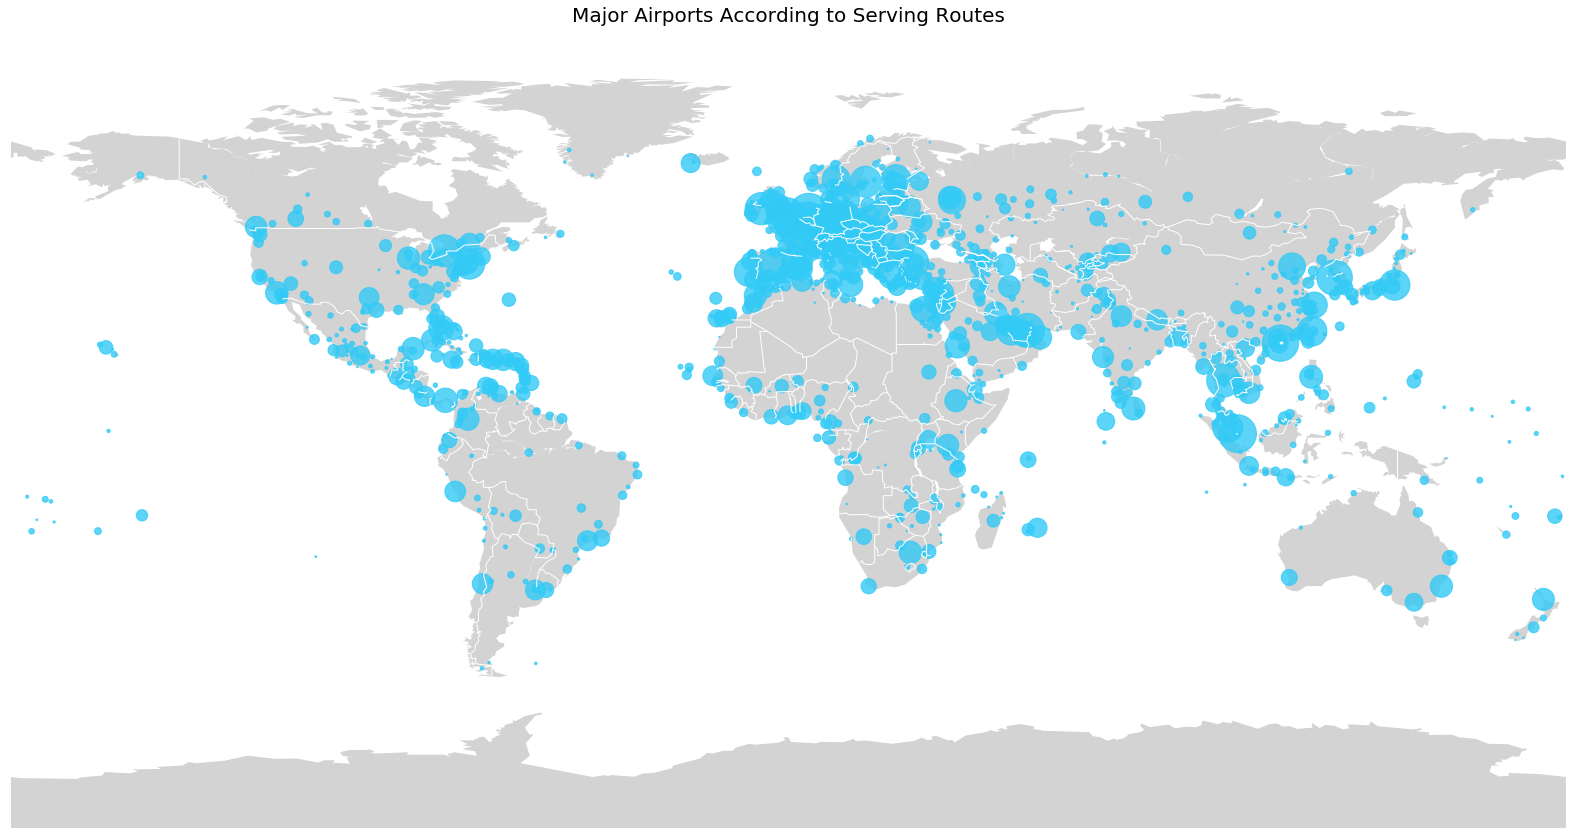

In [7]:
fig1 = plt.figure(figsize=(27,20))

ax = fig1.add_axes([0.1,0.1,0.8,0.8])

m.drawmapboundary(color='white', 
                  linewidth=0.0, 
                  fill_color='white')

m.drawcoastlines(linewidth=0)
m.fillcontinents('lightgray', 
                 lake_color='white')
m.drawcountries(linewidth=1, 
                linestyle='solid', 
                color='white', 
                zorder=30)

title = plt.title('Major Airports According to Serving Routes', 
                  fontsize=20) 
title.set_y(1.03) # Move the title a bit

m.readshapefile('../Extras/MyGeometries', 
                name='airports_shape', 
                drawbounds=False, 
                color='none')

out_traffic = [r['RoutesServ'] for r in m.airports_shape_info]
lats = [r['Latitude'] for r in m.airports_shape_info]
lons = [r['Longitude'] for r in m.airports_shape_info]
x1, y1 = m(lons, lats) # Convert coords to projected place in figure
m.scatter(x1, y1, 
          s=np.array(out_traffic), 
          marker="o", 
          color='#32caf6',
          zorder=10, 
          alpha=0.8)

plt.savefig('../Output/images/Major Airports According to Serving Routes.png', format='png', bbox_inches='tight')
plt.show()
plt.close()

- Let us see at one more representation of the Major Airports in plotly
- Click on each legend to toggle between Show/Hide of that category

In [8]:
major_hub['text'] = major_hub['Airport_start'] + '<br>City ' + major_hub['City_start']+ '<br>Country '\
                    + major_hub['Country_start']
limits = [(0,10),(11,40),(41,100),(101,500),(251,1160)]
colors = ["rgb(128,0,0)","rgb(220,20,60)","rgb(255,127,80)","rgb(233,150,122)","rgb(189, 183, 107)"]
airports = []
scale = [2, 4, 8, 10, 12]

for i in range(len(limits)):
    lim = limits[i]
    df_sub = major_hub[lim[0]:lim[1]]
    airport = dict(
        type = 'scattergeo',
        locationmode = 'country names',
        lon = df_sub['Longitude'],
        lat = df_sub['Latitude'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['RoutesServed']/scale[i],
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = 'Top {0}'.format(lim[1]))
    airports.append(airport)

layout = dict(
        title = 'Major hub airports of the world',
        showlegend = True,
        geo = dict(
            scope='world',
            projection=dict( type='equirectangular' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )

fig = dict( data=airports, layout=layout )
offline.iplot( fig, filename='Major hub airports of the world' )